In [14]:
# 환경 준비하기

import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [15]:
# Declaring Constants
IMAGE_PATH = "sample (1).jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [16]:
"""
def preprocess_image(image_path):
    """ """ Loads image from path and preprocesses to make it model ready
              Args:
            image_path: Path to the image file
    """ """
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # If PNG, remove the alpha channel. The model only supports
    # images with 3 color channels.
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]

    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    
    return tf.expand_dims(hr_image, 0)

"""

def save_image(image, filename):
    image = tf.squeeze(image)
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)

In [17]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [18]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [19]:
# Defining helper functions
def upscale_image(image):
    """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
    """
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

    lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] * 2, image_size[1] * 2],
              Image.BICUBIC))

    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

In [20]:
def _preprocess_image(image_path):
    """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
    """
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # If PNG, remove the alpha channel. The model only supports
    # images with 3 color channels.
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]

    hr_image = tf.cast(hr_image, tf.float32)
    
    return tf.expand_dims(hr_image, 0)

In [22]:
origin_image = _preprocess_image(IMAGE_PATH)

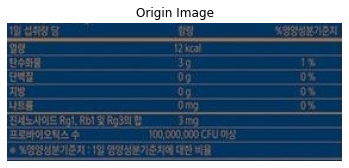

In [23]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(origin_image), title="Origin Image")
#plot_image(tf.squeeze(lr_image), title="UpScale Image")

In [24]:
save_image(origin_image, "origin_image_result.jpg")

Saved as origin_image_result.jpg.jpg


In [25]:
model = hub.load(SAVED_MODEL_PATH)

In [27]:
result = {}

for i in range(9):
    IMAGE_PATH = "sample (%d).jpg"%(i+1)
    img = _preprocess_image(IMAGE_PATH)

    start = time.time()
    fake_image = model(img)
    
    result[i] = fake_image
    
    print("Time Taken: %f" % (time.time() - start))
    
print("완료!")

Time Taken: 3.518393
Time Taken: 4.268040
Time Taken: 4.051579
Time Taken: 14.768159
Time Taken: 4.691213
Time Taken: 3.178079
Time Taken: 6.291043
Time Taken: 11.105360
Time Taken: 11.261199
완료!


In [28]:
for i in range(9):
    save_image(result[i],filename="result (%d)"%(i+1))

Saved as result (1).jpg
Saved as result (2).jpg
Saved as result (3).jpg
Saved as result (4).jpg
Saved as result (5).jpg
Saved as result (6).jpg
Saved as result (7).jpg
Saved as result (8).jpg
Saved as result (9).jpg


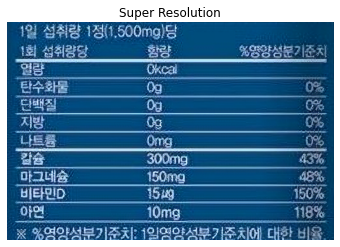

In [24]:
plot_image(tf.squeeze(result[1]), title="Super Resolution")

In [44]:
import cv2

filter_results = {}
sharp_results = {}

sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

for i in range(9):
    sharp_results[i] = cv2.filter2D(tf.squeeze(result[i]).numpy(), -1, sharpening_mask2)

for i in range(9):
    filter_results[i] = cv2.medianBlur(tf.squeeze(result[i]).numpy(), 5)
    save_image(filter_results[i],filename="medianFilter_result (%d)"%(i+1))

Saved as medianFilter_result (1).jpg
Saved as medianFilter_result (2).jpg
Saved as medianFilter_result (3).jpg
Saved as medianFilter_result (4).jpg
Saved as medianFilter_result (5).jpg
Saved as medianFilter_result (6).jpg
Saved as medianFilter_result (7).jpg
Saved as medianFilter_result (8).jpg
Saved as medianFilter_result (9).jpg


In [ ]:
import cv2

filter_results = {}

for i in range(9):
    # dst = cv2.bilateralFilter(tf.squeeze(result[i]).numpy(), -1, 10, 5)
    filter_results[i] = cv2.medianBlur(tf.squeeze(result[i]).numpy(), 5)
    save_image(filter_results[i],filename="medianFilter_result (%d)"%(i+1))

In [54]:
print(tf.squeeze(result[1]).shape)

(684, 1020, 3)


In [58]:
_filter_results = {}

for i in range(9):
    _filter_results[i] = cv2.GaussianBlur(tf.squeeze(result[i]).numpy(), (5,5), 0)
    save_image(_filter_results[i],filename="test_Filter_result (%d)"%(i+1))

Saved as test_Filter_result (1).jpg
Saved as test_Filter_result (2).jpg
Saved as test_Filter_result (3).jpg
Saved as test_Filter_result (4).jpg
Saved as test_Filter_result (5).jpg
Saved as test_Filter_result (6).jpg
Saved as test_Filter_result (7).jpg
Saved as test_Filter_result (8).jpg
Saved as test_Filter_result (9).jpg


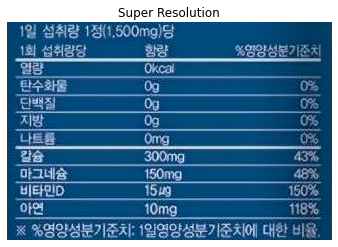

In [37]:
plot_image(dst, title="Super Resolution")

In [43]:
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

In [59]:
sharp_results = {}

for i in range(9):
    sharp_results[i] = cv2.filter2D(_filter_results[i], -1, sharpening_mask2)
    save_image(sharp_results[i],filename="test_sharp_result (%d)"%(i+1))

Saved as test_sharp_result (1).jpg
Saved as test_sharp_result (2).jpg
Saved as test_sharp_result (3).jpg
Saved as test_sharp_result (4).jpg
Saved as test_sharp_result (5).jpg
Saved as test_sharp_result (6).jpg
Saved as test_sharp_result (7).jpg
Saved as test_sharp_result (8).jpg
Saved as test_sharp_result (9).jpg
